In [1]:
import pandas as pd
import math
import numpy as np
import joblib
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from datetime import datetime
from time import time
from scipy.optimize import minimize
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

tqdm = partial(tqdm, position=0, leave=True)

C:\Users\sushant\anaconda3\envs\project\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\sushant\anaconda3\envs\project\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\sushant\anaconda3\envs\project\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"

Bad key text.latex.unicode in file C:\Users\sushant\anaconda3\envs\project\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\sushant\anaconda3\envs\project\lib\site-packages\matplotlib\mpl-data\styl

In [2]:
def read_df(keep_rooms=True):
  if keep_rooms:
    start = 526
    end = -6
  else:
    start = 524
    end = -4
  data1 = 'archive/TrainingData.csv'
  data2 = 'archive/ValidationData.csv'
  df1 = pd.read_csv(data1)
  df2 = pd.read_csv(data2)
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)
  df.drop(df.iloc[:, start:], inplace = True, axis = 1)

  to_remove = []
  for column in df.columns.tolist()[:end]:
    never_detected = True
    for rssi in df[column].tolist():
      if rssi <= 0:
        never_detected = False
        break
    if never_detected:
      to_remove.append(column)
  df.drop(to_remove, axis=1, inplace=True)

  return df

df = read_df()
print(f'There are {df.shape[0]} entries')
df.head()

C:\Users\sushant\AppData\Local\Temp\ipykernel_13576\1092699389.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)


There are 21048 entries


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,-7541.2643,4.864921e+06,2,1,106,2
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,-7536.6212,4.864934e+06,2,1,106,2
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,-7519.1524,4.864950e+06,2,1,103,2
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,-7524.5704,4.864934e+06,2,1,102,2
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,-7632.1436,4.864982e+06,0,0,122,2


In [3]:
counts = {}
for index, row in tqdm(df.iterrows()):
  for column in df.columns.tolist()[:-6]:
    counts[row[column]] = counts.get(row[column], 0) + 1

21048it [01:22, 253.91it/s]


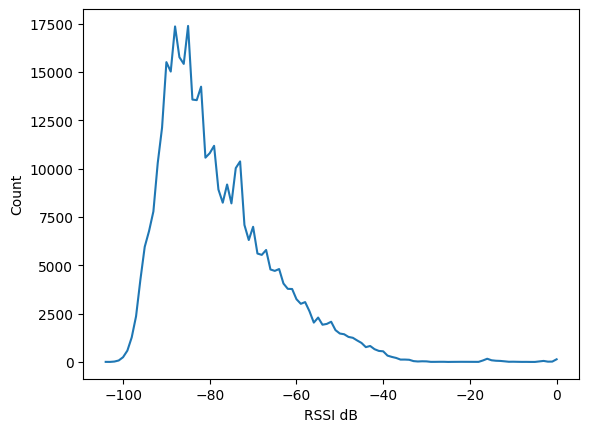

In [4]:
lists = sorted(counts.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x[:-1], y[:-1])
plt.ylabel("Count")
plt.xlabel("RSSI dB")
plt.show()

In [5]:
in_range = 0
tot = 0
start_range = -95
end_range = -73

for k, v in counts.items():
  if k >= start_range and k <= end_range:
    in_range += v
  if k != 100:
    tot += v

percentage_in_range = in_range * 100 / tot
print(f'The {percentage_in_range:.2f}% of non-null detection are in range [{start_range}, {end_range}] dB')

The 71.12% of non-null detection are in range [-95, -73] dB


In [6]:
ts = 0.2
random_state = 42

In [7]:
def assign_class(row, keep_rooms=True):
  if keep_rooms:
    return str(int(row['BUILDINGID'])) + '-' + str(int(row['FLOOR'])) + '-' + str(int(row['SPACEID'])) + '-' + str(int(row['RELATIVEPOSITION']))
  else:
    return str(int(row['BUILDINGID'])) + '-' + str(int(row['FLOOR']))

In [8]:
def toInteger(rssi):
  if rssi > 0:
    return 0
  return rssi + 105

In [9]:
def read_df_with_class(keep_rooms=True):
  df = read_df(keep_rooms=keep_rooms)
  df['class'] = df.apply(lambda row: assign_class(row, keep_rooms=keep_rooms), axis=1)
  if keep_rooms:
    end = -7
  else:
    end = -5
  df_classification = df.iloc[:, :end].applymap(lambda rssi: toInteger(rssi))
  df = pd.concat([df_classification, df.iloc[:, -1:]], axis=1)
  return df

In [10]:
# models labels
model_lbls = ['svc','knn','rfc']

# models parameters
tuned_param_svc = [{'kernel': ['rbf'], 
                    'cache_size': [8000], 
                    'gamma': ['scale', 1e-3, 1e-4],
                    'C': [10, 100, 1000]
                    },
                   {'kernel': ['linear'],
                    'cache_size': [8000],
                    'C': [10, 100, 1000]
                    }]
tuned_param_knn =[{'n_neighbors': list(range(1,11)),
                   'metric': ['euclidean', 'manhattan', 'chebyshev']}]
tuned_param_rfc =[{'max_depth': list(range(5,51,5))}]

# models
models = {
    'svc':{'name': 'Support Vector',
           'estimator': SVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn      
          },
    'rfc':{'name': 'Random Forest',
           'estimator': RandomForestClassifier(),
           'param': tuned_param_rfc
          }
}

scores = ['accuracy', 'f1_macro']

In [11]:
def print_results(model):
    print("Best parameters set found on train set:\n")
    print(model.best_params_)
    print("\nGrid scores on train set:\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params_tuple))
    print("\nScores for the best parameter set:\n")
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.\n")
    y_true, y_pred = y_test, model.predict(X_test)
    acc, f1 = accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')
    print(f'Accuracy: {acc:.2f}%')
    print(f'F1-macro: {f1:.2f}%')
    return acc, f1

In [12]:
def train_and_evaluate(X_train, y_train):  
  results_short = {}
  results = {}
  start = time()
  for score in scores:
      print('='*40)
      print("# Tuning hyper-parameters for %s \n" % score)
      for m in model_lbls:
          print('-'*40)
          print(f"Trying model {models[m]['name']}\n")
          # find optimal parameters for the model using grid search (cross validation)
          clf = GridSearchCV(models[m]['estimator'], 
                             models[m]['param'], 
                             cv=3,
                             scoring=score,
                             return_train_score = False,
                             n_jobs = -1, # this allows using multi-cores
                             verbose=0
                             )
          clf.fit(X_train, y_train.values.ravel())
          acc, f1 = print_results(clf)
          results_short[m] = (acc, f1)
          filename = models[m]['name'] + "_" + score + "_" + str(datetime.now().time())[:8] + '.sav'
          # save the model to disk
          # joblib.dump(clf.best_estimator_, filename)
          results[filename[:-13]] = {"accuracy" : acc,
                                     "f1-macro" : f1,
                                     "params" : clf.best_params_}
          # load the model from disk
          # loaded_model = joblib.load(filename)
      # summary of all computed estimators, using their best one param
      print('='*40)
      print(f"Summary of results of models tuned for {score}\n")
      print("Estimator\n")
      for m in results_short.keys():
          print(f"{models[m]['name']}\t - accuracy: {results_short[m][0]:4.2}%")
          print(f"{models[m]['name']}\t - f1-macro: {results_short[m][1]:4.2}%\n")
  end = time()
  print('='*40)
  print(f'train_and_evaluate executed in {end - start} seconds')
  return results

In [13]:
def print_evaluation_scores(results):
  for model, _ in results.items():
    params = ""
    for param_name, v in results[model]["params"].items():
      params += param_name + ": " + str(v) + ", "
    params = params[:-2]
    print("-"*40)
    print(f"{model}\t - accuracy: {results[model]['accuracy']:4.2}% with params=[{params}]")
    print(f"{model}\t - f1-macro: {results[model]['f1-macro']:4.2}% with params=[{params}]\n")

In [14]:
df = read_df_with_class(keep_rooms=True)
print(f'There are {df["class"].nunique()} unique classes')
df.head()

C:\Users\sushant\AppData\Local\Temp\ipykernel_13576\1092699389.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)


There are 918 unique classes


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1-2-106-2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1-2-106-2
2,0,0,0,0,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,1-2-103-2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1-2-102-2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0-0-122-2


In [15]:
train, test = train_test_split(df, test_size=ts, random_state=random_state)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, [-1]]
print(f"Training on {train.shape[0]} samples")
print(f"Testing on {test.shape[0]} samples")

Training on 16838 samples
Testing on 4210 samples


In [ ]:
results_predict_room = train_and_evaluate(X_train, y_train)

# Tuning hyper-parameters for accuracy 

----------------------------------------
Trying model Support Vector



C:\Users\sushant\anaconda3\envs\project\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
